In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/quality/'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [ ]:
train_img = sorted(os.listdir(path + '/train_input_img_resize_256'))
train_cleaned_img = sorted(os.listdir(path + '/train_label_img_resize_256'))
test_img = sorted(os.listdir(path + '/test_input_img_resize_256'))

In [ ]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (256, 256, 1))
    
    return img

In [ ]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train_input_img_resize_256/')):
    train.append(process_image(path + 'train_input_img_resize_256/' + f))

for f in sorted(os.listdir(path + 'train_label_img_resize_256/')):
    train_cleaned.append(process_image(path + 'train_label_img_resize_256/' + f))
   
for f in sorted(os.listdir(path + 'test_input_img_resize_256/')):
    test.append(process_image(path + 'test_input_img_resize_256/' + f))

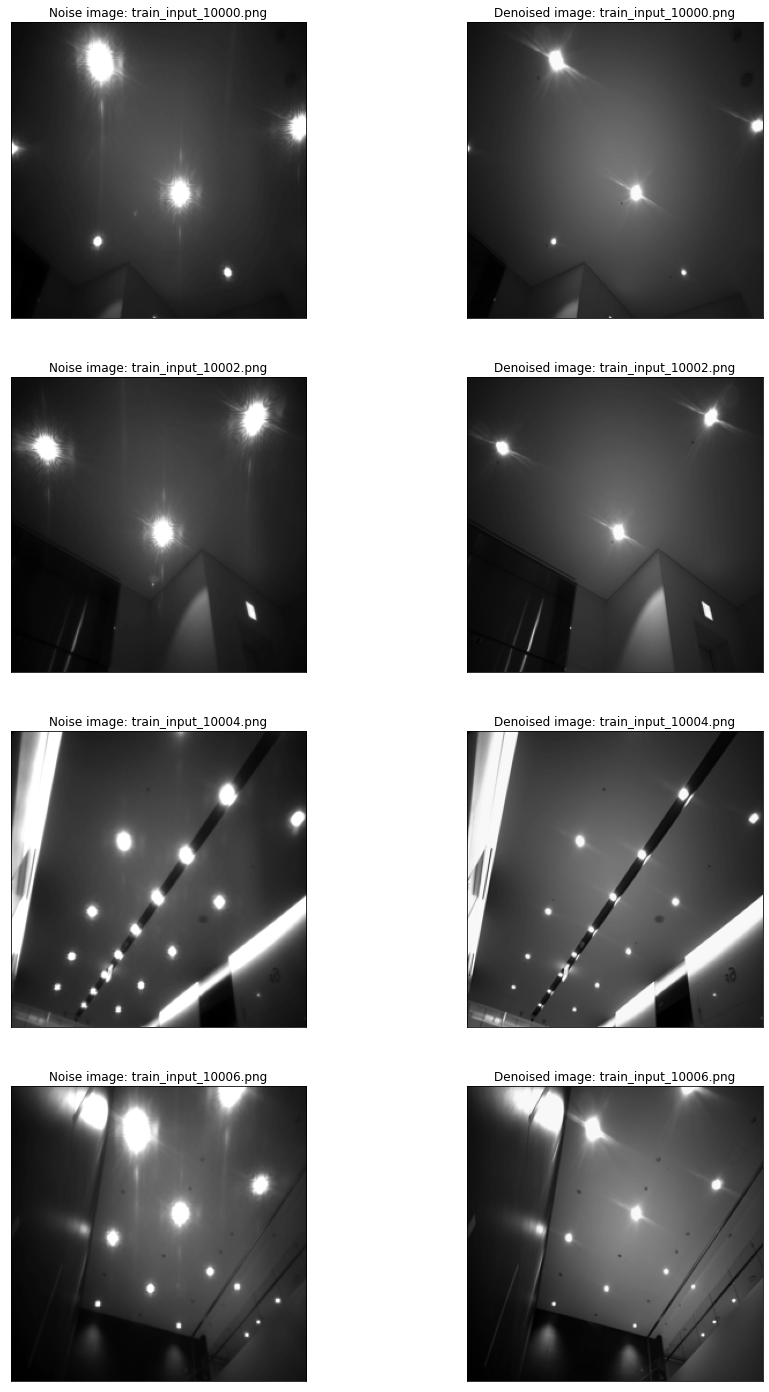

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [ ]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [ ]:
def model():
    input_layer = Input(shape=(256, 256, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     147584

In [ ]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/10
22/22 [==============================] - 324s 15s/step - loss: 0.0483 - mae: 0.1399 - val_loss: 0.0406 - val_mae: 0.1759
Epoch 2/10
22/22 [==============================] - 324s 15s/step - loss: 0.0179 - mae: 0.0860 - val_loss: 0.0234 - val_mae: 0.1220
Epoch 3/10
22/22 [==============================] - 323s 15s/step - loss: 0.0145 - mae: 0.0759 - val_loss: 0.0189 - val_mae: 0.1027
Epoch 4/10
22/22 [==============================] - 325s 15s/step - loss: 0.0129 - mae: 0.0700 - val_loss: 0.0318 - val_mae: 0.1304
Epoch 5/10
22/22 [==============================] - 325s 15s/step - loss: 0.0122 - mae: 0.0703 - val_loss: 0.0283 - val_mae: 0.1195
Epoch 6/10
22/22 [==============================] - 326s 15s/step - loss: 0.0110 - mae: 0.0624 - val_loss: 0.0260 - val_mae: 0.1179
Epoch 7/10
22/22 [==============================] - 325s 15s/step - loss: 0.0108 - mae: 0.0663 - val_loss: 0.0299 - val_mae: 0.1219
Epoch 8/10
22/22 [==============================] - 327s 15s/step - loss: 0.

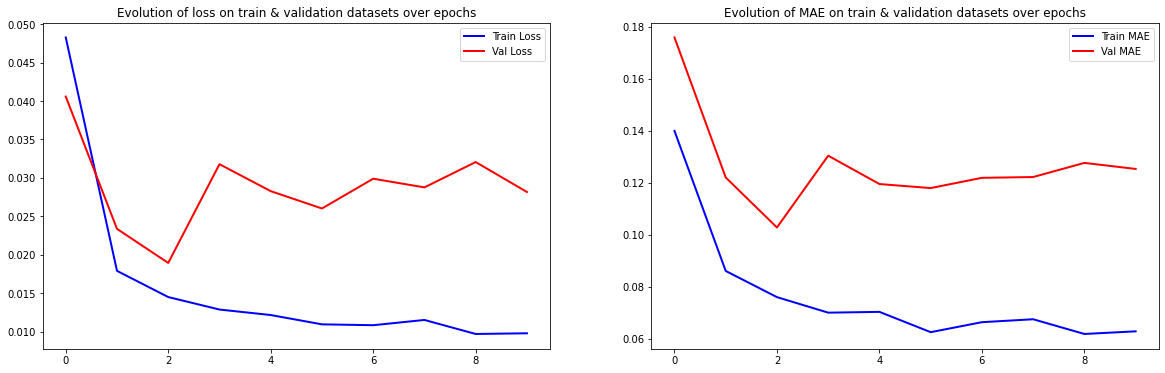

In [ ]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
Y_test = model.predict(X_test, batch_size=16)

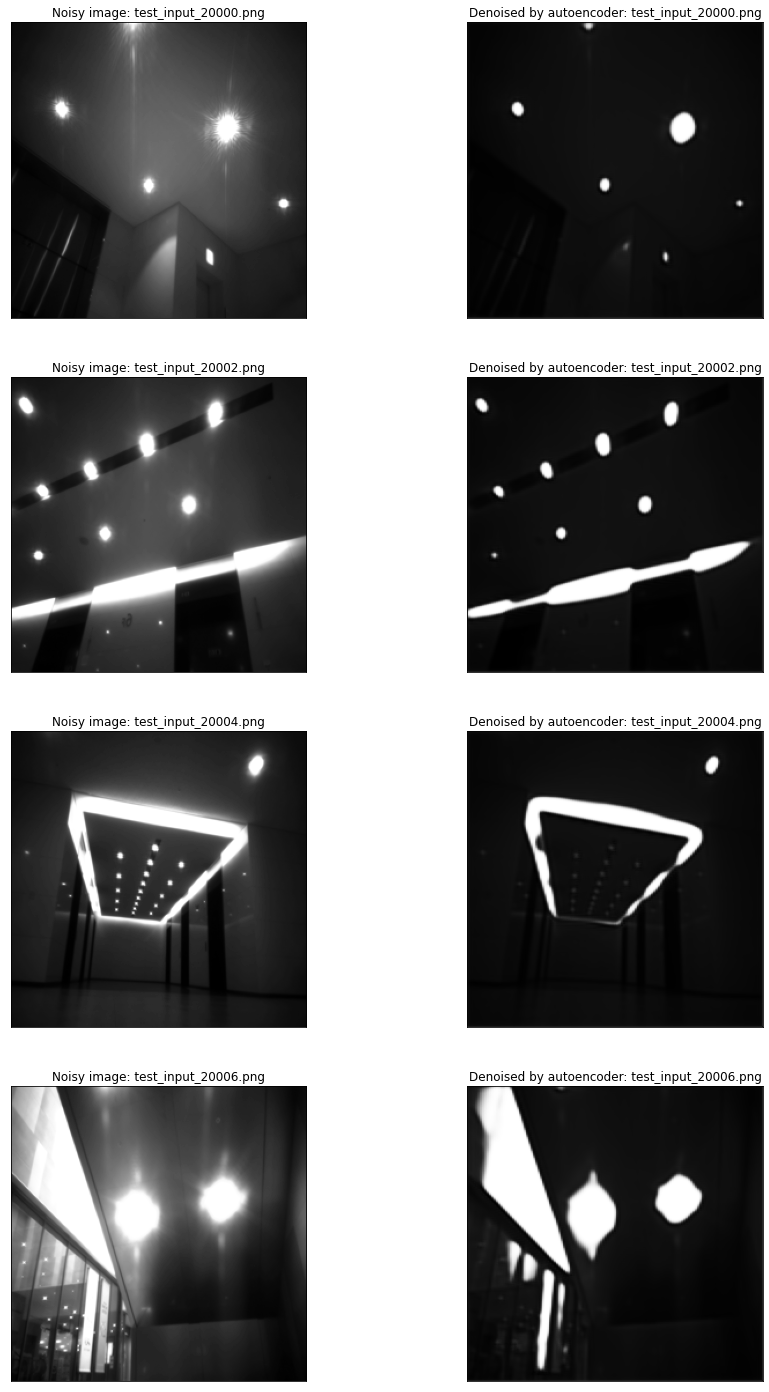

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
def make_submission(result):
    path = '/content/drive/MyDrive/quality/'
    os.makedirs(path+'submission_denoise', exist_ok=True)
    os.chdir(path+"submission_denoise/")
    sub_imgs = []
    for i, img in enumerate(result):
        path = f'test_{20000+i}.png'
        cv2.imwrite(path, img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("submission_denoise.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [ ]:
make_submission(Y_test)